In [1]:
import sys
import pandas
import sklearn
import imblearn
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import pyplot

#sklearn pre-processing 
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

# sklearn classifier model
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

# sklearn bagging and boosting 
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model ensemble learning 
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier

# xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance

# pandas.set_option('display.max_columns', None)
# pandas.set_option('display.max_rows', None)

### Read CSV

In [2]:
df = pandas.read_csv("ufcdata/data.csv").drop(columns = ["Referee", "R_fighter", "B_fighter", "location", "date"]).dropna().reset_index()
df = df.drop(columns = ["index"])
df.title_bout = df.title_bout.astype(int)

# conver the winner into int
df["Winner"][df["Winner"] == "Red"] = 1
df["Winner"][df["Winner"] == "Blue"] = 2
df["Winner"][df["Winner"] == "Draw"] = 3


df = df[df["Winner"] != "Draw"].reset_index(drop=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
# Count the Y distribtion 
df["Winner"].value_counts()

1    2023
2    1141
3      51
Name: Winner, dtype: int64

### EDA Work

In [4]:
# Get both player status 
R_status = []
B_status = []

# global status (referee, weight classes...etc)
global_status = []
for i in list(df.keys()):
    if("R_" in i[:3]):
        R_status.append(i)
    elif("B_" in i):
        B_status.append(i)
    else:
        global_status.append(i)
B_status.remove("B_Stance")
R_status.remove("R_Stance")

len(R_status), len(B_status)

(67, 67)

In [5]:
len(global_status)
global_status

['Winner', 'title_bout', 'weight_class', 'no_of_rounds']

In [6]:
# R_ and B_ Stance convert into one-hot
df1 = pandas.DataFrame()
for side in ["R_", "B_"]:
    keys = list(sorted(df[side+"Stance"].unique()))
    lis = list()
    for i in df[side+"Stance"].tolist():
        zero = np.zeros((1,len(keys)))
        zero[0][keys.index(i)] = 1
        lis.append(zero[0])
    _keys = []
    
    for i in keys: # rename columns 
        _keys.append(side+i)
        
    df_temp = pandas.DataFrame(lis, columns = _keys)
    
    for i in df_temp.keys(): # append together
        df1[i] = df_temp[i]
df1.tail()

,R_Open Stance,R_Orthodox,R_Southpaw,R_Switch,B_Open Stance,B_Orthodox,B_Southpaw,B_Switch
3210,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3211,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3212,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3213,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3214,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# Weight class feature to one-hot

keys = list(sorted(df["weight_class"].unique()))
lis = list()

for i in df["weight_class"].tolist():
    zero = np.zeros((1,len(keys)))
    zero[0][keys.index(i)] = 1
    lis.append(zero[0])

df2 = pandas.DataFrame(lis, columns = keys).astype('float')

df2.tail()

,Bantamweight,Catch Weight,Featherweight,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
3210,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3212,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3214,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Combine three dataframe
temp_df = df

drop_list = ["R_Stance", "B_Stance", "weight_class"]
df = (pandas.concat([df, df1,df2], axis=1)).drop(columns = drop_list)
df = df.astype('float')
df


,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Flyweight,Heavyweight,Light Heavyweight,Lightweight,Middleweight,Welterweight,Women's Bantamweight,Women's Featherweight,Women's Flyweight,Women's Strawweight
0,1.0,1.0,5.0,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,5.0,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,3.0,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,0.0,3.0,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,3.0,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,3.0,0.0,3.0,0.0,15.000000,7.416667,6.083333,3.416667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.0,0.0,3.0,1.0,0.0,0.0,16.250000,11.000000,17.500000,11.250000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,2.0,0.0,3.0,0.0,1.0,0.0,7.250000,4.750000,1.750000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,3.0,0.0,1.0,0.0,25.400000,17.900000,22.500000,16.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,2.0,0.0,3.0,1.0,0.0,0.0,5.428571,4.142857,12.285714,9.142857,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# The differeance between two fighter
new_key = []
for i in B_status:
    new_key.append(i.replace("B_", "Difference_"))

df3 = pandas.DataFrame(df[B_status].to_numpy() - df[R_status].to_numpy(), columns = new_key)
df3.tail()


,Difference_current_lose_streak,Difference_current_win_streak,Difference_draw,Difference_avg_BODY_att,Difference_avg_BODY_landed,Difference_avg_CLINCH_att,Difference_avg_CLINCH_landed,Difference_avg_DISTANCE_att,Difference_avg_DISTANCE_landed,Difference_avg_GROUND_att,...,Difference_win_by_Decision_Split,Difference_win_by_Decision_Unanimous,Difference_win_by_KO/TKO,Difference_win_by_Submission,Difference_win_by_TKO_Doctor_Stoppage,Difference_wins,Difference_Height_cms,Difference_Reach_cms,Difference_Weight_lbs,Difference_age
3210,0.0,1.0,0.0,5.523810,5.238095,5.714286,5.714286,-1.619048,2.285714,-10.619048,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3211,0.0,0.0,0.0,8.333333,8.000000,-10.666667,-6.333333,-22.000000,-8.666667,44.666667,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3212,-1.0,1.0,0.0,4.400000,4.900000,8.700000,10.200000,-11.600000,-2.900000,-27.100000,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3213,-2.0,1.0,0.0,6.500000,4.000000,33.500000,19.500000,45.500000,18.000000,4.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3214,0.0,1.0,0.0,0.166667,0.166667,8.666667,4.000000,2.666667,1.666667,0.333333,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [10]:
# Combine df3 as well
df = pandas.concat([df, df3], axis=1)
df.tail()

,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,Difference_win_by_Decision_Split,Difference_win_by_Decision_Unanimous,Difference_win_by_KO/TKO,Difference_win_by_Submission,Difference_win_by_TKO_Doctor_Stoppage,Difference_wins,Difference_Height_cms,Difference_Reach_cms,Difference_Weight_lbs,Difference_age
3210,1.0,1.0,5.0,0.0,3.0,0.0,7.666667,6.666667,10.000000,7.0,...,0.0,-1.0,0.0,0.0,-1.0,-2.0,-7.62,0.00,-20.0,4.0
3211,1.0,0.0,3.0,0.0,1.0,0.0,12.000000,10.000000,6.000000,3.0,...,0.0,0.0,0.0,0.0,-1.0,-1.0,-12.70,-5.08,42.0,-1.0
3212,1.0,1.0,5.0,0.0,1.0,0.0,7.000000,6.500000,14.500000,12.0,...,0.0,0.0,-1.0,0.0,-1.0,-2.0,-10.16,0.00,0.0,-2.0
3213,1.0,0.0,2.0,0.0,1.0,0.0,9.000000,6.000000,36.000000,21.0,...,0.0,1.0,0.0,0.0,0.0,1.0,2.54,5.08,20.0,6.0
3214,1.0,0.0,2.0,0.0,3.0,0.0,0.666667,0.666667,8.666667,4.0,...,0.0,0.0,2.0,-1.0,0.0,1.0,-2.54,-2.54,-20.0,-14.0


In [11]:
Y = df["Winner"].tolist()

In [12]:
# scale data 
scale_df = df.drop(columns = ["Winner"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
df = scale_df


In [13]:
df["Winner"] = Y

In [14]:
df["Winner"].value_counts()

1.0    2023
2.0    1141
3.0      51
Name: Winner, dtype: int64

### Feature Importance

In [32]:
                             
X = df.drop(columns = ["Winner"])
Y =  df["Winner"]

In [33]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X,Y)
importances = forest.feature_importances_

In [34]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 223 Difference_age (0.010819)
2. feature 135 R_age (0.008620)
3. feature 96 R_losses (0.007206)
4. feature 106 R_avg_opp_HEAD_landed (0.006490)
5. feature 185 Difference_losses (0.006327)
6. feature 125 R_win_by_Decision_Split (0.006110)
7. feature 113 R_avg_opp_SIG_STR_landed (0.006087)
8. feature 134 B_age (0.006027)
9. feature 102 R_avg_opp_DISTANCE_landed (0.005915)
10. feature 207 Difference_avg_opp_TD_pct (0.005812)
11. feature 203 Difference_avg_opp_SIG_STR_pct (0.005747)
12. feature 13 B_avg_HEAD_att (0.005690)
13. feature 114 R_avg_opp_SIG_STR_pct (0.005671)
14. feature 10 B_avg_DISTANCE_landed (0.005661)
15. feature 24 B_avg_TD_att (0.005642)
16. feature 92 R_avg_TD_pct (0.005627)
17. feature 20 B_avg_SIG_STR_att (0.005623)
18. feature 5 B_avg_BODY_att (0.005524)
19. feature 52 B_avg_opp_TD_pct (0.005498)
20. feature 6 B_avg_BODY_landed (0.005487)
21. feature 21 B_avg_SIG_STR_landed (0.005465)
22. feature 9 B_avg_DISTANCE_att (0.005439)
23. feature

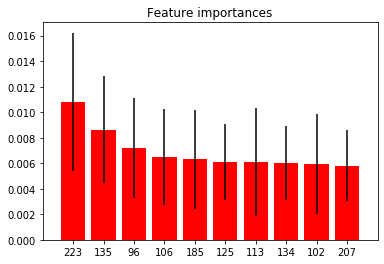

In [61]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[:10]],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

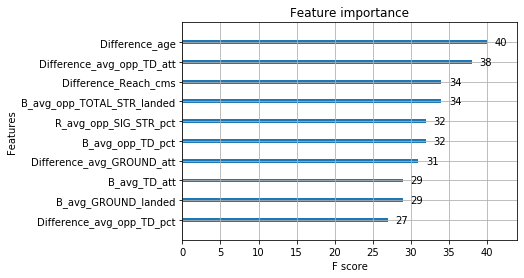

In [63]:
model = XGBClassifier()
model.fit(X, Y)

# plot feature importance
plot_importance(model, max_num_features= 10)
pyplot.show()

In [40]:
def feat_importance(m, df):
    return pandas.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = feat_importance(model, X); fi[:10]

,Feature,Importance
113,R_avg_opp_SIG_STR_landed,0.027519
223,Difference_age,0.018228
185,Difference_losses,0.012974
20,B_avg_SIG_STR_att,0.011523
21,B_avg_SIG_STR_landed,0.011158
13,B_avg_HEAD_att,0.011058
193,Difference_avg_opp_GROUND_landed,0.009489
9,B_avg_DISTANCE_att,0.008872
77,R_avg_GROUND_att,0.008863
194,Difference_avg_opp_HEAD_att,0.008743


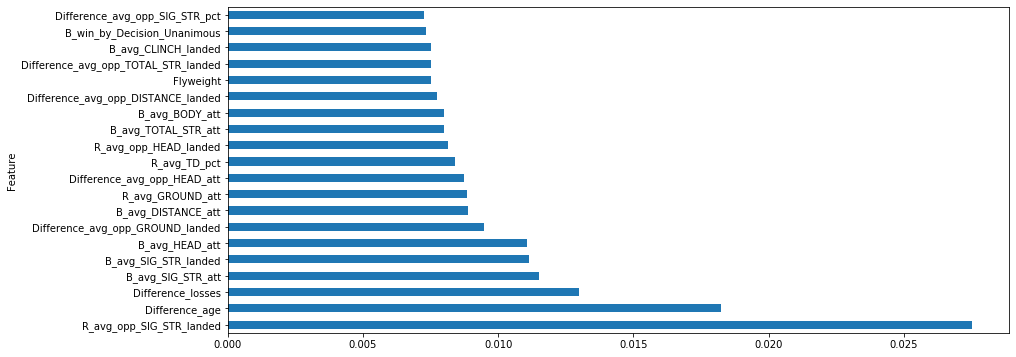

In [55]:
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

In [66]:
df3

,Difference_current_lose_streak,Difference_current_win_streak,Difference_draw,Difference_avg_BODY_att,Difference_avg_BODY_landed,Difference_avg_CLINCH_att,Difference_avg_CLINCH_landed,Difference_avg_DISTANCE_att,Difference_avg_DISTANCE_landed,Difference_avg_GROUND_att,...,Difference_win_by_Decision_Split,Difference_win_by_Decision_Unanimous,Difference_win_by_KO/TKO,Difference_win_by_Submission,Difference_win_by_TKO_Doctor_Stoppage,Difference_wins,Difference_Height_cms,Difference_Reach_cms,Difference_Weight_lbs,Difference_age
0,0.0,0.0,0.0,-12.700000,-10.400000,-16.800000,-11.000000,-12.400000,-5.900000,-6.800000,...,-1.0,-4.0,0.0,1.0,0.0,-4.0,5.08,7.62,0.0,-1.0
1,0.0,1.0,0.0,2.600000,1.385714,2.514286,0.442857,36.557143,5.957143,-16.028571,...,1.0,-1.0,0.0,-2.0,1.0,-1.0,2.54,0.00,0.0,1.0
2,0.0,-8.0,0.0,1.488172,2.655914,3.875269,2.653763,-31.391398,-10.886022,0.182796,...,-1.0,4.0,7.0,0.0,-1.0,9.0,5.08,-7.62,0.0,1.0
3,-1.0,4.0,0.0,-1.250000,3.750000,7.875000,6.875000,4.625000,7.750000,12.000000,...,-1.0,-2.0,1.0,0.0,0.0,-2.0,7.62,-2.54,0.0,-3.0
4,-1.0,1.0,0.0,9.250000,7.750000,-8.500000,-5.250000,150.250000,34.750000,-0.500000,...,0.0,0.0,-2.0,0.0,0.0,-2.0,-7.62,-5.08,-14.0,6.0
5,0.0,0.0,0.0,-10.166667,-10.833333,-7.916667,-7.666667,12.333333,5.250000,-11.000000,...,0.0,-3.0,2.0,0.0,0.0,-1.0,-2.54,-15.24,0.0,3.0
6,-1.0,0.0,0.0,-8.972222,-6.555556,-10.055556,-9.527778,-50.027778,-9.777778,-0.777778,...,-1.0,-2.0,0.0,0.0,0.0,-3.0,5.08,5.08,0.0,-8.0
7,0.0,0.0,0.0,-1.083333,-1.983333,-5.450000,-5.900000,70.733333,29.550000,1.816667,...,0.0,-2.0,-2.0,-3.0,0.0,-7.0,7.62,2.54,0.0,-6.0
8,0.0,-2.0,0.0,16.066667,12.566667,11.833333,9.466667,-123.233333,-42.066667,1.266667,...,0.0,1.0,0.0,0.0,0.0,1.0,-5.08,2.54,0.0,5.0
9,0.0,0.0,0.0,-3.571429,0.142857,-5.714286,-2.857143,-101.142857,-44.285714,5.142857,...,0.0,0.0,2.0,0.0,0.0,2.0,-7.62,-12.70,0.0,0.0


In [80]:
X = df3

In [81]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=0)

forest.fit(X,Y)
importances = forest.feature_importances_

In [82]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,10):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df3.keys()[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 66 Difference_age (0.028522)
2. feature 28 Difference_losses (0.018839)
3. feature 50 Difference_avg_opp_TD_pct (0.017255)
4. feature 64 Difference_Reach_cms (0.017246)
5. feature 57 Difference_win_by_Decision_Split (0.017015)
6. feature 46 Difference_avg_opp_SIG_STR_pct (0.016766)
7. feature 39 Difference_avg_opp_KD (0.016579)
8. feature 23 Difference_avg_TD_landed (0.016393)
9. feature 36 Difference_avg_opp_GROUND_landed (0.016211)
10. feature 53 Difference_total_rounds_fought (0.016015)


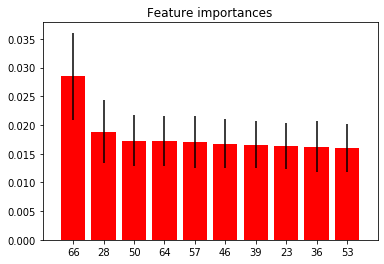

In [83]:
plt.figure()
plt.title("Feature importances")
plt.bar(range(0,10), importances[indices[:10]],
       color="r", yerr=std[indices][:10], align="center")
plt.xticks(range(0,10), indices)
plt.xlim([-1, 10])
plt.show()

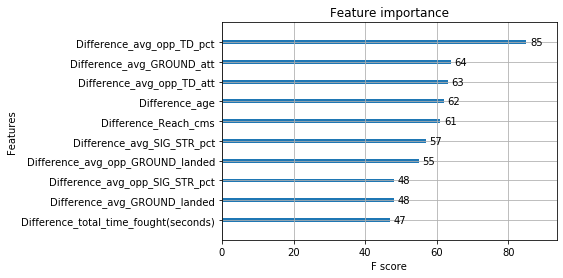

In [84]:
model = XGBClassifier()
model.fit(X, Y)

# plot feature importance
plot_importance(model, max_num_features= 10)
pyplot.show()

In [85]:
def feat_importance(m, df):
    return pandas.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}).sort_values('Importance', ascending=False)


fi = feat_importance(model, X); fi[:10]

,Feature,Importance
66,Difference_age,0.047595
28,Difference_losses,0.034561
57,Difference_win_by_Decision_Split,0.026238
36,Difference_avg_opp_GROUND_landed,0.024770
1,Difference_current_win_streak,0.021978
45,Difference_avg_opp_SIG_STR_landed,0.021793
3,Difference_avg_BODY_att,0.021374
46,Difference_avg_opp_SIG_STR_pct,0.019976
39,Difference_avg_opp_KD,0.019262
38,Difference_avg_opp_HEAD_landed,0.019040


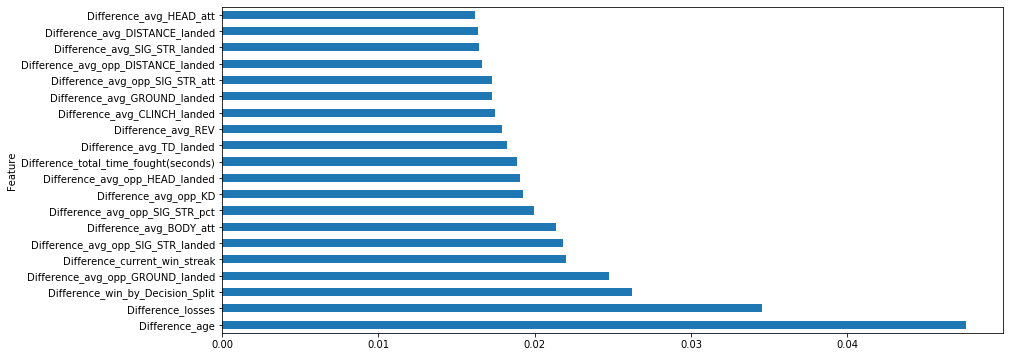

In [90]:
plot1 = fi[:20].plot('Feature', 'Importance', figsize=(14,6), legend=False, kind = 'barh')
plot1;

### Sampling the dataset

In [ ]:
# over_sampling for "draw / 3".
X = df.drop(columns = ["Winner"])

rus = imblearn.over_sampling.ADASYN(ratio={3:300 }, random_state=1)

X_rus, Y_rus = rus.fit_sample(X, Y)

print(Counter(Y_rus))


In [ ]:
sampled_df = pandas.DataFrame(X_rus, dtype = float, columns = df.drop(columns = ["Winner"]).keys())
sampled_df["Winner"] = Y_rus
df = sampled_df

### Dataset 

In [ ]:
# dataset = shuffle(sampled_df)
dataset = shuffle(df)


Train_dataset = dataset[100:-200] 
Valid_dataset = dataset[:100] # 100 dataset for valid
Test_dataset = dataset[-200:] # 200 dataset for test

Train_X = Train_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Train_Y = Train_dataset["Winner"].to_numpy(dtype = int)


Valid_X = Valid_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Valid_Y = Valid_dataset["Winner"].to_numpy(dtype = int)


Test_X = Test_dataset.drop(columns = ["Winner"]).to_numpy(dtype = float)
Test_Y = Test_dataset["Winner"].to_numpy(dtype = int)
pandas.DataFrame(Test_Y, columns = ["Y"])["Y"].value_counts(), 


In [ ]:
pandas.DataFrame(Train_Y, columns = ["Y"])["Y"].value_counts()

In [ ]:
pandas.DataFrame(Valid_Y, columns = ["Y"])["Y"].value_counts()

# ML Models

### Ensembling learning method

In [ ]:
# Bagging for the model and return the best selection via given datasets
rng = np.random.RandomState(1)

def Bagging(model, Train_X, Train_Y, Vail_X, Vail_Y):  
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    for i in range(1, 20):
        Bagging_Model = BaggingClassifier(base_estimator= model, n_estimators = i, bootstrap=True, warm_start=False) #
        Bagging_Model.fit(Train_X, Train_Y)
        curr_score = Bagging_Model.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest



In [ ]:
# Adam boost for the model and return the best selection via given datasets
def Ada_Model(model, Train_X, Train_Y, Vail_X, Vail_Y):
    highest = 0
    coeff = 0
    rng = np.random.RandomState(1)
    for i in range(1, 20):
        AdaBoost_model = AdaBoostClassifier(base_estimator=model, n_estimators=i, random_state=rng)
        AdaBoost_model.fit(Train_X, Train_Y)
        curr_score = AdaBoost_model.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest



In [ ]:
# GBDT(Gradient Boosting Decision Tree) for the model and return the best selection via given datasets


def GBDT(model, Train_X, Train_Y, Vail_X, Vail_Y):
    coeff = 0
    highest = 0
    _range = np.arange(0.01, 1, 0.05)
    for i in (_range):
        GBDT = GradientBoostingClassifier(init = model, learning_rate = i)
        GBDT.fit(Train_X, Train_Y)
        curr_score = GBDT.score(Vail_X, Vail_Y)
        if(highest < curr_score):
            highest = curr_score
            coeff = i
    return coeff, highest

### Naive Bayes Classifier

In [ ]:
NB = MultinomialNB(class_prior = [0.9,0.95,0.75], alpha = 1)
NB.fit(Train_X, Train_Y)
NB.score(Train_X, Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, NB.predict(Train_X)) )

In [ ]:
NB.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, NB.predict(Test_X)) )

In [ ]:
# Bagging Naive Bayes model
coeff, highest = Bagging(NB, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
Bagging_NB = BaggingClassifier(base_estimator=NB, n_estimators=coeff, random_state=rng)
Bagging_NB.fit(Train_X, Train_Y)
Bagging_NB.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_NB.predict(Train_X)) )

In [ ]:
Bagging_NB.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_NB.predict(Test_X)) )

In [ ]:
# Gradient Boosting Decision Tree Naive Bayes model 
coeff, highest = GBDT(Bagging_NB, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
GBDT_NB = GradientBoostingClassifier(init = Bagging_NB, learning_rate = coeff)
GBDT_NB.fit(Train_X, Train_Y)
GBDT_NB.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_NB.predict(Train_X)) )

In [ ]:
GBDT_NB.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_NB.predict(Test_X)) )

### KNN Classifier

In [ ]:
KNN = KNeighborsClassifier(weights= "distance")


KNN.fit(Train_X, Train_Y)
KNN.score(Train_X, Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, KNN.predict(Train_X)) )

In [ ]:
KNN.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, KNN.predict(Test_X)) )

In [ ]:
# Bagging KNN model
coeff, highest = Bagging(KNN, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
Bagging_KNN = BaggingClassifier(base_estimator=KNN, n_estimators=coeff, random_state=rng)
Bagging_KNN.fit(Train_X, Train_Y)
Bagging_KNN.score(Train_X,Train_Y)

In [ ]:
Bagging_KNN.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_KNN.predict(Test_X)) )

In [ ]:
# Gradient Boosting Decision Tree KNN model 

coeff, highest = GBDT(Bagging_KNN, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
GBDT_KNN = GradientBoostingClassifier(init = Bagging_KNN, learning_rate = coeff)
GBDT_KNN.fit(Train_X, Train_Y)
GBDT_KNN.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_KNN.predict(Train_X)) )

In [ ]:
GBDT_KNN.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_KNN.predict(Test_X)) )

### SVC Classifier

In [ ]:
svc = SVC(gamma='scale', kernel = "rbf", degree = 225, C = 10)


svc.fit(Train_X, Train_Y)
svc.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, svc.predict(Train_X)) )

In [ ]:
svc.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, svc.predict(Test_X)) )

In [ ]:
# Bagging Support Vector Classifier model
coeff, highest = Bagging(svc, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
Bagging_SVC = BaggingClassifier(base_estimator=svc, n_estimators=coeff, random_state=rng)
Bagging_SVC.fit(Train_X, Train_Y)
Bagging_SVC.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_SVC.predict(Train_X)) )

In [ ]:
Bagging_SVC.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_SVC.predict(Test_X)) )

In [ ]:
# Gradient Boosting Decision Tree Support Vector Classifier model 

coeff, highest = GBDT(Bagging_SVC, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
GBDT_SVC = GradientBoostingClassifier(init = Bagging_SVC, learning_rate = coeff)
GBDT_SVC.fit(Train_X, Train_Y)
GBDT_SVC.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_SVC.predict(Train_X)) )

In [ ]:
GBDT_SVC.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_SVC.predict(Test_X)) )

### Random Forest

In [ ]:
RF = RandomForestClassifier(random_state=0)
RF.fit(Train_X, Train_Y)
RF.score(Train_X, Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, RF.predict(Train_X)) )

In [ ]:
RF.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, RF.predict(Test_X)) )

In [ ]:
# Bagging Random Forest 
coeff, highest = Bagging(RF, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
Bagging_RF = BaggingClassifier(base_estimator=RF, n_estimators=coeff, random_state=rng)
Bagging_RF.fit(Train_X, Train_Y)
Bagging_RF.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, Bagging_RF.predict(Train_X)) )

In [ ]:
Bagging_RF.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, Bagging_RF.predict(Test_X)) )

In [ ]:
# Gradient Boosting Decision Tree Random Forest model 

coeff, highest = GBDT(Bagging_RF, Train_X, Train_Y, Valid_X, Valid_Y)
coeff, highest

In [ ]:
GBDT_RF = GradientBoostingClassifier(init = Bagging_RF, learning_rate = coeff)
GBDT_RF.fit(Train_X, Train_Y)
GBDT_RF.score(Train_X,Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, GBDT_RF.predict(Train_X)) )

In [ ]:
GBDT_RF.score(Test_X,Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, GBDT_RF.predict(Test_X)) )

### Ensembling Learning

### Voting 

In [ ]:
model_list = [GBDT_RF, GBDT_SVC, GBDT_NB, KNN]
model_list_labels = ["GBDT_RF", "GBDT_SVC", "GBDT_NB", "KNN"]


lists = []
for i in zip(model_list_labels,model_list):
    lists.append(i)

In [ ]:
VC_models = VotingClassifier(estimators=lists)
VC_models.fit(Train_X, Train_Y)
VC_models.score(Train_X, Train_Y)

In [ ]:
print(sklearn.metrics.classification_report(Train_Y, VC_models.predict(Train_X)) )

In [ ]:
VC_models.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, VC_models.predict(Test_X)) )

### Stacking 

In [ ]:
Stacking_X = np.append(Train_X, Valid_X,  axis=0)
Stacking_Y = np.append(Train_Y, Valid_Y)

In [ ]:
meta = MLPClassifier(alpha = 25, solver = "adam", activation = "relu", max_iter = 1000) # early stop
model_list = [GBDT_RF, GBDT_SVC, GBDT_NB, KNN]


SC_models = StackingClassifier(classifiers=model_list, meta_classifier=meta)
SC_models.fit(Stacking_X, Stacking_Y)
SC_models.score(Stacking_X, Stacking_Y)

In [ ]:
print(sklearn.metrics.classification_report(Stacking_Y, SC_models.predict(Stacking_X)))

In [ ]:
SC_models.score(Test_X, Test_Y)

In [ ]:
print(sklearn.metrics.classification_report(Test_Y, SC_models.predict(Test_X)) )

### Visualisation 

In [ ]:
# model_list = [GBDT_RF, Bagging_SVC, GBDT_NB, KNN]
# model_list_labels = ["GBDT_RF", "Bagging_SVC", "GBDT_NB", "KNN"]


num = 50
xt = Test_X[:num]

alpha = 0.6
plt.figure(figsize=(18,9))
plt.plot(GBDT_RF.predict(xt), 'gd',alpha = alpha, label='GBDT_RF')
plt.plot(GBDT_SVC.predict(xt), 'ko',alpha = alpha, label='GBDT_SVC')
plt.plot(GBDT_NB.predict(xt), 'b^',alpha = alpha, label='GBDT_NB')
plt.plot(KNN.predict(xt), 'r+',alpha = alpha, label='KNN')
plt.plot(VC_models.predict(xt), 'cs',alpha = alpha, label='Voting Models')
plt.plot(SC_models.predict(xt), 'yp',alpha = alpha, label='Stacking Models')
plt.plot(Test_Y[:num], 'black', label='Y_Real')


plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted')
plt.xlabel('training samples')
plt.legend(loc="best")
plt.title('Comparison of individual predictions with averaged')
plt.savefig('result.pdf')
plt.show()


